In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import xgboost as xgb
import lightgbm as lgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv
/kaggle/input/liverpool-ion-switching/train.csv


In [2]:
train = pd.read_csv('../input/liverpool-ion-switching/train.csv')
test = pd.read_csv('../input/liverpool-ion-switching/test.csv')
sample = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')
print(train.shape, test.shape)

(5000000, 3) (2000000, 2)


In [3]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
time             float64
signal           float64
open_channels    int64
dtypes: float64(2), int64(1)
memory usage: 114.4 MB


In [5]:
print(train.isna().any().sum(), test.isna().any().sum())

0 0


Cool, we have no missing values and all columns are numeric type.

KeyboardInterrupt: 

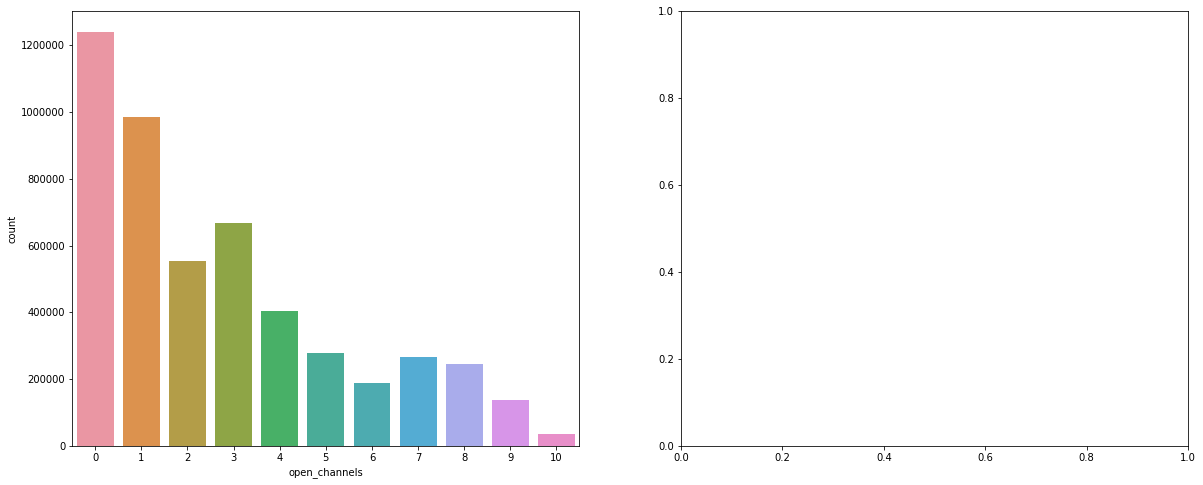

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.countplot(train.open_channels, ax=ax[0])
sns.distplot(train.open_channels, ax=ax[1])

Classification. Higher number of open channels are less frequent. Let's check how open_channels vary with time. 

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x='time', y='open_channels', data=train)

Insights:
1. Values 0 and 1 for open_channels is very frequent as compared to other values.
2. Values >= 6 occur between 200s and 250s and then between 450s and 500s. Seasonality? Maybe
3. Values 2 and 3 occur between 150s and 300s and then between 350s and 500s. 

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x='time', y='signal', hue='open_channels', data=train[train['time'] < 100])

Cool. So, we can say that a single channel is opened only when the value of signal > -2.

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x='time', y='signal', hue='open_channels', data=train[(train['time'] > 100) & (train['time'] < 200)])

Clearly, the number of open channels increases with increase in signal. This graph is in tune with our time vs open_channels graph.

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x='time', y='signal', hue='open_channels', data=train[(train['time'] > 200) & (train['time'] < 300)])

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x='time', y='signal', hue='open_channels', data=train[(train['time'] > 300) & (train['time'] < 400)])

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x='time', y='signal', hue='open_channels', data=train[train['time'] > 400])

Seasonality.

In [7]:
split = int(train.shape[0] * 0.7)
X_train = train[:split]
X_val = train[split:]
print(X_train.shape, X_val.shape)

(3500000, 3) (1500000, 3)


In [8]:
y_train = X_train['open_channels']
y_val = X_val['open_channels']

X_train = X_train.drop(['open_channels','time'], axis=1)
X_val = X_val.drop(['open_channels','time'], axis=1)

In [9]:
params = {
    'eta':0.1, 
    'n_estimators':100, 
    'max_depth':7,
    'objective':'softmax',
    'silent':False
}

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), eval_metric='multiclass', early_stopping_rounds=10, verbose=True)

[1]	valid_0's multi_logloss: 3.66591
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 3.49317
[3]	valid_0's multi_logloss: 3.52505
[4]	valid_0's multi_logloss: 3.56059
[5]	valid_0's multi_logloss: 3.59876
[6]	valid_0's multi_logloss: 3.63893
[7]	valid_0's multi_logloss: 3.68076
[8]	valid_0's multi_logloss: 3.72389
[9]	valid_0's multi_logloss: 3.76807
[10]	valid_0's multi_logloss: 3.81308
[11]	valid_0's multi_logloss: 3.85876
[12]	valid_0's multi_logloss: 3.90496
Early stopping, best iteration is:
[2]	valid_0's multi_logloss: 3.49317


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eta=0.1, importance_type='split', learning_rate=0.1, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='softmax',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
preds = model.predict(X_val)
f1_score(preds, y_val, average='macro')

0.021231174338469147

In [ ]:
# feature_importances = pd.DataFrame({'col': X_train.columns,'imp':model.feature_importances_})
# feature_importances = feature_importances.sort_values(by='imp',ascending=False)
# sns.barplot(y='col',x='imp', data=feature_importances)

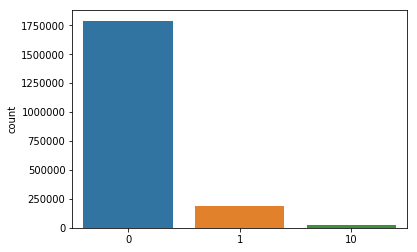

In [11]:
test_pred = model.predict(test.drop(['time'], axis=1))
sns.countplot(test_pred)

In [12]:
test['open_channels'] = list(test_pred)
test

,time,signal,open_channels
0,500.0001,-2.6498,0
1,500.0002,-2.8494,0
2,500.0003,-2.8600,0
3,500.0004,-2.4350,0
4,500.0005,-2.6155,0
...,...,...,...
1999995,699.9996,-2.9092,0
1999996,699.9997,-2.7422,0
1999997,699.9998,-2.8285,0
1999998,699.9999,-2.9092,0


In [13]:
sample['open_channels'] = test['open_channels']
sample.to_csv('submission.csv', index=False, float_format='%.4f')

TypeError: to_csv() got an unexpected keyword argument 'floatformat'